# Collaborative Filtering

[Link](https://realpython.com/build-recommendation-engine-collaborative-filtering/)

### User-Based vs Item-Based Collaborative Filtering

The two approaches are mathematically quite similar, but there is a conceptual difference between the two. Here’s how the two compare:

+ **User-based**: For a user U, with a set of similar users determined based on rating vectors consisting of given item ratings, the rating for an item I, which hasn’t been rated, is found by picking out N users from the similarity list who have rated the item I and calculating the rating based on these N ratings.

+ **Item-based**: For an item I, with a set of similar items determined based on rating vectors consisting of received user ratings, the rating by a user U, who hasn’t rated it, is found by picking out N items from the similarity list that have been rated by U and calculating the rating based on these N ratings.

# Surprise Library - KNN

In [285]:
import pandas as pd
import numpy as np

In [286]:
from surprise import Dataset
from surprise import Reader

from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SVD
from surprise import accuracy
from surprise import SlopeOne
from surprise import SVDpp
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNWithZScore
from surprise import CoClustering

from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

from surprise import accuracy

RSEED = 42

In [287]:
links = pd.read_csv('../data/ml-latest-small/links.csv')
movies = pd.read_csv('../data/ml-latest-small/movies.csv')
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
tags = pd.read_csv('../data/ml-latest-small/tags.csv')

In [288]:
movie_user_matrix = ratings.pivot_table('rating','movieId','userId')
df = movie_user_matrix.fillna(0)
df2 = df.merge(movies, how='left', on='movieId')

In [289]:
# make a dataframe with only the movies which received ratings

rated_movies = df2[['movieId', 'title', 'genres']]
rated_movies.shape

(9724, 3)

#### Define Reader &
#### Load the data frame into data

In [290]:
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

## KNNBaseline (item-based == 'user_based': False)

In [291]:
# Retrieve the trainset.
trainset = data.build_full_trainset()

sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }


# Build an algorithm, and train it.
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [292]:
# check actual rating
ratings[(ratings['movieId']==1 & (ratings['userId']==414))]

,userId,movieId,rating,timestamp
62294,414,1,4.0,961438127


In [293]:
# get a prediction for specific users and items.
# user 414 and movie 1 (and specify he's actual rating r_ui)
pred = algo.predict(414, 1, r_ui=4.0, verbose=True)

user: 414        item: 1          r_ui = 4.00   est = 4.22   {'actual_k': 40, 'was_impossible': False}


In [294]:
# predictions for movie 1 and the first 10 users
for u in ratings['userId'].unique()[:10]:
    pred = algo.predict(u, 1, verbose=True)

user: 1          item: 1          r_ui = None   est = 4.44   {'actual_k': 40, 'was_impossible': False}
user: 2          item: 1          r_ui = None   est = 3.91   {'actual_k': 16, 'was_impossible': False}
user: 3          item: 1          r_ui = None   est = 1.83   {'actual_k': 15, 'was_impossible': False}
user: 4          item: 1          r_ui = None   est = 3.80   {'actual_k': 40, 'was_impossible': False}
user: 5          item: 1          r_ui = None   est = 4.01   {'actual_k': 29, 'was_impossible': False}
user: 6          item: 1          r_ui = None   est = 4.28   {'actual_k': 40, 'was_impossible': False}
user: 7          item: 1          r_ui = None   est = 4.21   {'actual_k': 40, 'was_impossible': False}
user: 8          item: 1          r_ui = None   est = 3.99   {'actual_k': 31, 'was_impossible': False}
user: 9          item: 1          r_ui = None   est = 4.18   {'actual_k': 16, 'was_impossible': False}
user: 10         item: 1          r_ui = None   est = 3.40   {'actual_k':

In [295]:
# get the actual ratings for movie 1 and each user who rated it
movie_ratings = ratings[ratings['movieId']==1]

user_rating = {}
for index, row in movie_ratings.iterrows():
    user_rating[row['userId']] = row['rating']

In [296]:
# make dictionaries for actual and predicted ratings
actual = {}
predicted = {}

for k, v in user_rating.items():
    pred = algo.predict(k, 1, r_ui=v, verbose=True)
    actual[k] = v
    predicted[k] = pred.est

user: 1.0        item: 1          r_ui = 4.00   est = 4.44   {'actual_k': 40, 'was_impossible': False}
user: 5.0        item: 1          r_ui = 4.00   est = 4.01   {'actual_k': 29, 'was_impossible': False}
user: 7.0        item: 1          r_ui = 4.50   est = 4.21   {'actual_k': 40, 'was_impossible': False}
user: 15.0       item: 1          r_ui = 2.50   est = 3.10   {'actual_k': 40, 'was_impossible': False}
user: 17.0       item: 1          r_ui = 4.50   est = 4.29   {'actual_k': 40, 'was_impossible': False}
user: 18.0       item: 1          r_ui = 3.50   est = 3.81   {'actual_k': 40, 'was_impossible': False}
user: 19.0       item: 1          r_ui = 4.00   est = 3.59   {'actual_k': 40, 'was_impossible': False}
user: 21.0       item: 1          r_ui = 3.50   est = 3.53   {'actual_k': 40, 'was_impossible': False}
user: 27.0       item: 1          r_ui = 3.00   est = 3.76   {'actual_k': 40, 'was_impossible': False}
user: 31.0       item: 1          r_ui = 5.00   est = 4.59   {'actual_k':

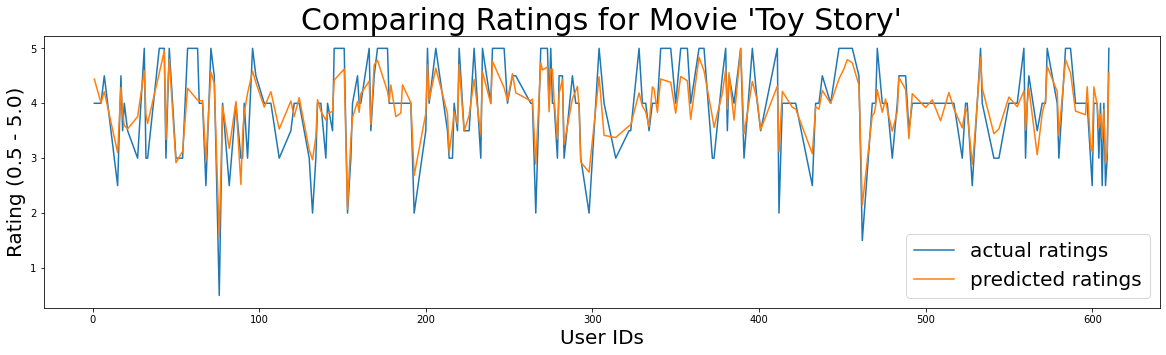

In [297]:
# plotting movie ratings for Toy Story
# actual vs predicted

plt.rcParams["figure.figsize"] = (20,5)

lists = sorted(actual.items()) # sorted by key, return a list of tuples
lists2 = sorted(predicted.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples
w, z = zip(*lists2)

plt.title("Comparing Ratings for Movie 'Toy Story'", fontsize=30)
plt.xlabel('User IDs', fontsize=20)
plt.ylabel('Rating (0.5 - 5.0)', fontsize=20)

plt.plot(x, y, label='actual ratings')
plt.plot(w,z, label='predicted ratings')
plt.legend(loc='lower right', fontsize=20)
plt.show()

In [298]:
# Trying to build a test set and to predict
# takes over 5 minutes

#testset = trainset.build_anti_testset()
#predictions = algo.test(testset)

In [299]:
# strangely low RMSE (0.54)
#accuracy.rmse(predictions)

### Try another way for the train-test-split
#### to use for the top n recommendations and k nearest neighbors

In [300]:
trainset, testset = train_test_split(data, test_size=.25, random_state=RSEED)

sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8629


0.8629362646985598

### Top N Recommendations

#### Predictions based on the user ratings and user profile
#### to predict movies the user hasn't seen yet

In [301]:
# from the surprise documentation
# with the extension of a recommendation dictionary

from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# First train an SVD algorithm on the movielens dataset.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
# and make a dictionary to store user ID and movie ID
recommendations = {}
for uid, user_ratings in top_n.items():
    print(uid,[iid for (iid, _) in user_ratings])
    recommendations[uid] = [iid for (iid, _) in user_ratings]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
1 [318, 908, 912, 1276, 1262, 4466, 750, 4294, 7153, 161922]
2 [160718, 7327, 3992, 100882, 112460, 136602, 50003, 188301, 73042, 1034]
3 [1004, 2733, 3064, 3190, 3370, 3901, 4079, 85, 104925, 634]
4 [26524, 71429, 5113, 779, 70946, 43869, 4092, 40870, 568, 26116]
5 [6239, 112804, 389, 3330, 26810, 51937, 67186, 6235, 8782, 38304]
6 [53, 32289, 60516, 80615, 4429, 70641, 70305, 3042, 74282, 6858]
7 [4207, 511, 2977, 4337, 4708, 1341, 4711, 92422, 142115, 1624]
8 [7486, 549, 5279, 1085, 4297, 27664, 635, 3963, 6884, 31431]
9 [70946, 64032, 134368, 159817, 4079, 74508, 151739, 26184, 64116, 100507]
10 [130087, 7395, 80727, 6143, 112460, 5529, 184791, 109848, 68959, 97866]
11 [89759, 96829, 6239, 1564, 8341, 2749, 3546, 1949, 80862, 82053]
12 [260, 608, 1210, 1258, 1298, 1804, 1927, 2502, 3578, 318]
13 [750, 858, 1204, 1208, 260, 1221, 1089, 318, 2959, 50]
14 [26704, 7087, 

In [302]:
# get recommendations for user (based on user profile and all users' ratings)

def get_recomm_for_user(user):
    for i,j in enumerate(recommendations[user]):
        movie = rated_movies[rated_movies['movieId']==j].title
        print('{}. Movie Recommendation: {}'.format(i+1, movie.iloc[0]))

get_recomm_for_user(1)

1. Movie Recommendation: Shawshank Redemption, The (1994)
2. Movie Recommendation: North by Northwest (1959)
3. Movie Recommendation: Casablanca (1942)
4. Movie Recommendation: Cool Hand Luke (1967)
5. Movie Recommendation: Great Escape, The (1963)
6. Movie Recommendation: Above the Law (1988)
7. Movie Recommendation: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
8. Movie Recommendation: 5,000 Fingers of Dr. T, The (1953)
9. Movie Recommendation: Lord of the Rings: The Return of the King, The (2003)
10. Movie Recommendation: The Edge of Seventeen (2016)


#### Preparation for k nearest neighbors

In [303]:
rid_to_name = {}
for index, row in rated_movies.iterrows():
    rid_to_name[row['movieId']] = row['title']

In [304]:
name_to_rid = {}
for index, row in rated_movies.iterrows():
    name_to_rid[row['title']] = row['movieId']

### K nearest Neighbors:

In [306]:
# Largely taken from surprise webside

# Retrieve inner id of the movie Toy Story
toy_story_raw_id = name_to_rid['Toy Story (1995)']
toy_story_inner_id = algo.trainset.to_inner_iid(toy_story_raw_id)

# Retrieve inner ids of the nearest neighbors of Toy Story.
toy_story_neighbors = algo.get_neighbors(toy_story_inner_id, k=10)

# Convert inner ids of the neighbors into names.
toy_story_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in toy_story_neighbors)
toy_story_neighbors = (rid_to_name[rid]
                       for rid in toy_story_neighbors)

print()
print('The 10 nearest neighbors of Toy Story are:')
for movie in toy_story_neighbors:
    print(movie)


The 10 nearest neighbors of Toy Story are:
Toy Story 2 (1999)
Aladdin (1992)
Incredibles, The (2004)
Finding Nemo (2003)
Back to the Future (1985)
Toy Story 3 (2010)
Babe (1995)
E.T. the Extra-Terrestrial (1982)
Ghostbusters (a.k.a. Ghost Busters) (1984)
Monsters, Inc. (2001)


#### Cross Validation

In [307]:
# Retrieve the trainset.
trainset = data.build_full_trainset()

sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }


# Build an algorithm, and train it.
algo_cross = KNNBaseline(sim_options=sim_options)

# Run 5-fold cross-validation and print results
cross_validate(algo_cross, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8509  0.8515  0.8495  0.8541  0.8580  0.8528  0.0030  
MAE (testset)     0.6482  0.6498  0.6495  0.6518  0.6549  0.6508  0.0023  
Fit time          4.45    4.32    4.37    3.96    3.92    4.20    0.22    
Test time         3.32    3.46    3.20    3.16    3.2

{'test_rmse': array([0.85093251, 0.85146903, 0.84949849, 0.8540975 , 0.8580173 ]),
 'test_mae': array([0.64818975, 0.6498245 , 0.64950148, 0.65182428, 0.65488847]),
 'fit_time': (4.452722787857056,
  4.316036701202393,
  4.365846157073975,
  3.957115888595581,
  3.916520118713379),
 'test_time': (3.3164398670196533,
  3.4622020721435547,
  3.196563959121704,
  3.1567223072052,
  3.2019529342651367)}

#### Other train-test-split:

(but something is not right: too low RMSE...)

In [308]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }

algo = KNNBaseline(sim_options=sim_options)

trainset = data.build_full_trainset()
algo.fit(trainset)

testset = trainset.build_testset()
predictions = algo.test(testset)

accuracy.rmse(predictions, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3287


0.32868914068957056

In [310]:
# Retrieve the trainset.
trainset = data.build_full_trainset()

sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }


# Build an algorithm, and train it.
algo = KNNBaseline(sim_options=sim_options)

# Note that you can train and test an algorithm with the following one-line:
predictions = algo.fit(trainset).test(testset)

accuracy.rmse(predictions, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3287


0.32868914068957056